In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/herlev-dataset-dl-models/pytorch/default/1/best_efficientnet_b0.pth
/kaggle/input/herlev-dataset-dl-models/pytorch/default/1/best_alexnet.pth
/kaggle/input/herlev-dataset-dl-models/pytorch/default/1/best_cnn_transformer.pth
/kaggle/input/herlev-dataset-dl-models/pytorch/default/1/best_resnet50.pth
/kaggle/input/herlev-dataset/Herlev Dataset/test/normal_intermediate/209522940-209523052-001.BMP
/kaggle/input/herlev-dataset/Herlev Dataset/test/normal_intermediate/209566047-209566125-001.BMP
/kaggle/input/herlev-dataset/Herlev Dataset/test/normal_intermediate/209566399-209566517-001.BMP
/kaggle/input/herlev-dataset/Herlev Dataset/test/normal_intermediate/209565409-209565600-001.BMP
/kaggle/input/herlev-dataset/Herlev Dataset/test/normal_intermediate/209522940-209522991-001.BMP
/kaggle/input/herlev-dataset/Herlev Dataset/test/normal_intermediate/209565864-209565911-001.BMP
/kaggle/input/herlev-dataset/Herlev Dataset/test/normal_intermediate/209565698-209565772-001.BMP
/kaggle/

Using device: cpu
Class mapping: {'carcinoma_in_situ': 0, 'light_dysplastic': 1, 'moderate_dysplastic': 2, 'normal_columnar': 3, 'normal_intermediate': 4, 'normal_superficiel': 5, 'severe_dysplastic': 6}

📂 Loading TRAIN set...
  Loading 105 images from 'carcinoma_in_situ'...
  Loading 128 images from 'light_dysplastic'...
  Loading 103 images from 'moderate_dysplastic'...
  Loading 69 images from 'normal_columnar'...
  Loading 49 images from 'normal_intermediate'...
  Loading 51 images from 'normal_superficiel'...
  Loading 138 images from 'severe_dysplastic'...

📂 Loading TEST set...
  Loading 45 images from 'carcinoma_in_situ'...
  Loading 54 images from 'light_dysplastic'...
  Loading 43 images from 'moderate_dysplastic'...
  Loading 29 images from 'normal_columnar'...
  Loading 21 images from 'normal_intermediate'...
  Loading 23 images from 'normal_superficiel'...
  Loading 59 images from 'severe_dysplastic'...

✅ Dataset Loaded Successfully!
Train samples: 643, Test samples: 274

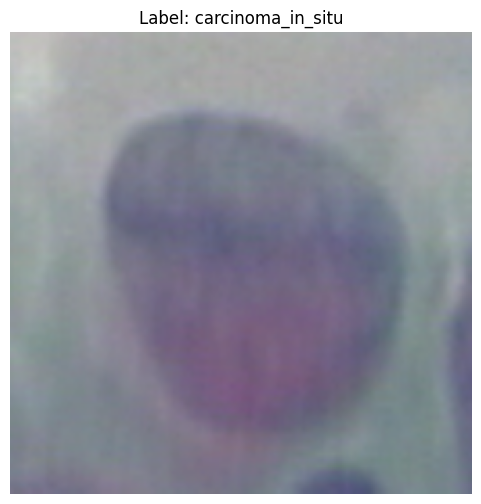

In [2]:
# =========================================
# 📦 Imports
# =========================================
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob

# =========================================
# ⚙️ Device
# =========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =========================================
# 📁 Dataset Paths
# =========================================
data_root = "/kaggle/input/herlev-dataset/Herlev Dataset"
train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")

# Define the seven cell-type folders
cell_types = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

# Map each cell type to a numeric label
label_map = {name: idx for idx, name in enumerate(cell_types)}
print(f"Class mapping: {label_map}")

# Standard image size for CNNs
image_size = (224,224)

# =========================================
# 🧩 Helper Function to Load Images
# =========================================
# =========================================
# 🧩 Helper Function to Load Images (supports .bmp and .jpg)
# =========================================
def load_images_from_folder(base_dir, cell_types, label_map):
    X, y = [], []
    for cell_type in cell_types:
        folder_path = os.path.join(base_dir, cell_type)
        # Collect both .bmp and .jpg images
        images = glob(os.path.join(folder_path, "*.BMP")) + glob(os.path.join(folder_path, "*.jpg"))
        
        print(f"  Loading {len(images)} images from '{cell_type}'...")
        for img_path in images:
            img = cv2.imread(img_path)
            if img is None:
                continue  # skip corrupted/unreadable files
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(label_map[cell_type])
    return np.array(X, dtype=np.uint8), np.array(y, dtype=np.int32)


# =========================================
# 📥 Load Train and Test Sets (as provided)
# =========================================
print("\n📂 Loading TRAIN set...")
X_train, y_train = load_images_from_folder(train_dir, cell_types, label_map)

print("\n📂 Loading TEST set...")
X_test, y_test = load_images_from_folder(test_dir, cell_types, label_map)

print(f"\n✅ Dataset Loaded Successfully!")
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# =========================================
# 🔢 Normalize and Convert to Tensors
# =========================================
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert (N, H, W, C) → (N, C, H, W)
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

# Convert to tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# =========================================
# 🧺 Create DataLoaders
# =========================================
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("\n✅ DataLoaders ready!")
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

# =========================================
# 👀 Visualize Random Sample
# =========================================
plt.figure(figsize=(6, 6))
idx = np.random.randint(0, len(X_train))
plt.imshow(np.transpose(X_train[idx].numpy(), (1, 2, 0)))
plt.title(f"Label: {list(label_map.keys())[y_train[idx].item()]}")
plt.axis("off")
plt.show()


In [3]:
# =========================================
# 🧱 Training Function with Validation Accuracy + Early Stopping + Model Saving
# =========================================
def train_model(model, criterion, optimizer, train_loader, test_loader, model_name,
                num_epochs=30, patience=5, save_dir="./models"):
    
    os.makedirs(save_dir, exist_ok=True)
    best_acc = 0.0
    patience_counter = 0
    train_losses, val_losses, val_accuracies = [], [], []
    best_model_path = os.path.join(save_dir, f"best_{model_name}.pth")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        preds, true_labels = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_loss /= len(test_loader.dataset)
        val_losses.append(val_loss)
        val_acc = accuracy_score(true_labels, preds)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1:02d}/{num_epochs}] | "
              f"Train Loss: {epoch_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⏹️ Early stopping triggered for {model_name}.")
            break

    print(f"💾 Best model for {model_name} saved to {best_model_path} (Acc: {best_acc:.4f})")
    model.load_state_dict(torch.load(best_model_path))
    return model, train_losses, val_losses, val_accuracies, best_acc


# =========================================
# 🧠 Initialize Pretrained Models (VGG19 Removed)
# =========================================
def initialize_model(model_name, num_classes=7):  # 4 classes for LBC dataset
    if model_name == "alexnet":
        model = models.alexnet(weights="IMAGENET1K_V1")
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Unknown model name. Choose 'alexnet' or 'resnet50'.")
    
    return model.to(device)



========================= Training ALEXNET =========================


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 194MB/s]


Epoch [01/30] | Train Loss: 1.5602 | Val Loss: 1.6925 | Val Acc: 0.1861
Epoch [02/30] | Train Loss: 1.2145 | Val Loss: 1.6445 | Val Acc: 0.3577
Epoch [03/30] | Train Loss: 1.0061 | Val Loss: 1.9523 | Val Acc: 0.3504
Epoch [04/30] | Train Loss: 0.9378 | Val Loss: 1.9278 | Val Acc: 0.3394
Epoch [05/30] | Train Loss: 0.8091 | Val Loss: 2.0989 | Val Acc: 0.3650
Epoch [06/30] | Train Loss: 0.7129 | Val Loss: 1.9984 | Val Acc: 0.4051
Epoch [07/30] | Train Loss: 0.5195 | Val Loss: 2.3886 | Val Acc: 0.3686
Epoch [08/30] | Train Loss: 0.4453 | Val Loss: 2.6327 | Val Acc: 0.3942
Epoch [09/30] | Train Loss: 0.4171 | Val Loss: 3.0598 | Val Acc: 0.3540
Epoch [10/30] | Train Loss: 0.3044 | Val Loss: 2.5414 | Val Acc: 0.3942
Epoch [11/30] | Train Loss: 0.2978 | Val Loss: 2.6463 | Val Acc: 0.3686
⏹️ Early stopping triggered for alexnet.
💾 Best model for alexnet saved to ./models/best_alexnet.pth (Acc: 0.4051)

✅ Final Test Accuracy (alexnet): 0.4051
                     precision    recall  f1-score  

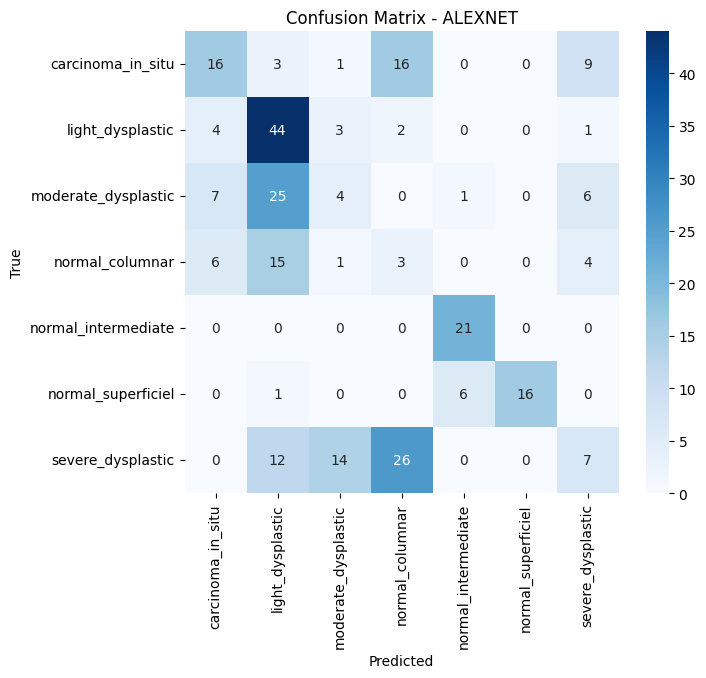

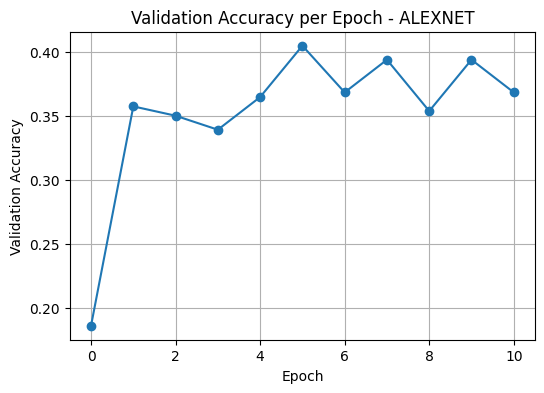


========================= Training RESNET50 =========================


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


Epoch [01/30] | Train Loss: 1.3188 | Val Loss: 1.5933 | Val Acc: 0.3905
Epoch [02/30] | Train Loss: 0.5590 | Val Loss: 2.4740 | Val Acc: 0.2555
Epoch [03/30] | Train Loss: 0.2334 | Val Loss: 2.1779 | Val Acc: 0.3577
Epoch [04/30] | Train Loss: 0.1340 | Val Loss: 2.6578 | Val Acc: 0.3358
Epoch [05/30] | Train Loss: 0.1491 | Val Loss: 2.3928 | Val Acc: 0.3248
Epoch [06/30] | Train Loss: 0.1366 | Val Loss: 2.8339 | Val Acc: 0.3394
⏹️ Early stopping triggered for resnet50.
💾 Best model for resnet50 saved to ./models/best_resnet50.pth (Acc: 0.3905)

✅ Final Test Accuracy (resnet50): 0.3905
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.23      0.49      0.31        45
   light_dysplastic       0.47      0.67      0.55        54
moderate_dysplastic       0.00      0.00      0.00        43
    normal_columnar       0.00      0.00      0.00        29
normal_intermediate       1.00      0.24      0.38        21
 normal_superficiel       0.58      0.96 

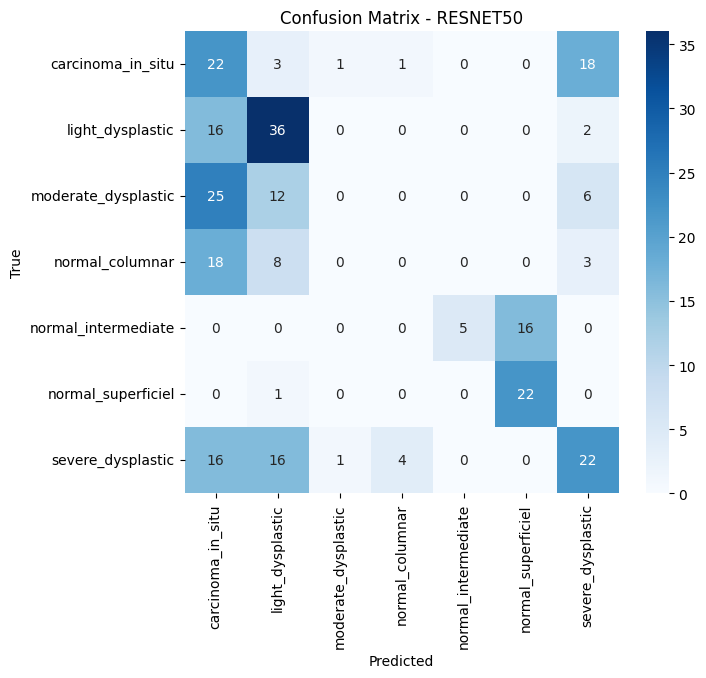

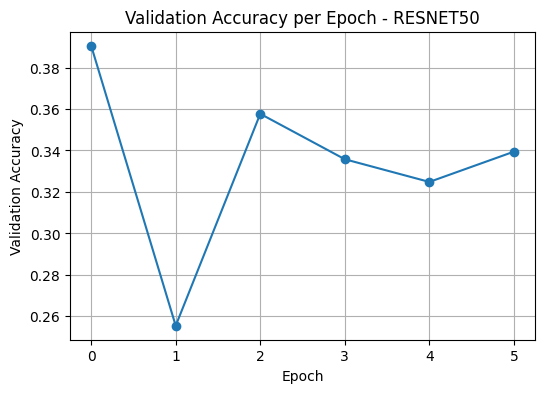

In [4]:
# =========================================
# 🚀 Train and Evaluate All Models (LBC Dataset)
# =========================================
models_to_train = ["alexnet", "resnet50"]  # Removed VGG19
results = {}

# Updated class names for Mendeley LBC dataset
class_names = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

for name in models_to_train:
    print(f"\n{'='*25} Training {name.upper()} {'='*25}")
    model = initialize_model(name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model, train_losses, val_losses, val_accuracies, best_acc = train_model(
        model, criterion, optimizer, train_loader, test_loader,
        model_name=name, num_epochs=30, patience=5, save_dir="./models"
    )

    # =========================================
    # 🧾 Final Evaluation
    # =========================================
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Final Test Accuracy ({name}): {acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=2))

    # =========================================
    # 🔹 Confusion Matrix Visualization
    # =========================================
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[c[:20] for c in class_names],  # shorter labels
                yticklabels=[c[:20] for c in class_names])
    plt.title(f"Confusion Matrix - {name.upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # =========================================
    # 📈 Validation Accuracy Curve
    # =========================================
    plt.figure(figsize=(6, 4))
    plt.plot(val_accuracies, marker='o')
    plt.title(f"Validation Accuracy per Epoch - {name.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.grid(True)
    plt.show()

    results[name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "best_acc": best_acc
    }


In [5]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 


========================= Training EFFICIENTNET_B0 =========================


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch [01/30] | Train Loss: 2.7664 | Val Loss: 24.7240 | Val Acc: 0.1241
Epoch [02/30] | Train Loss: 0.7368 | Val Loss: 2.6766 | Val Acc: 0.2993
Epoch [03/30] | Train Loss: 0.2685 | Val Loss: 2.5671 | Val Acc: 0.3467
Epoch [04/30] | Train Loss: 0.1784 | Val Loss: 2.9105 | Val Acc: 0.3431
Epoch [05/30] | Train Loss: 0.1243 | Val Loss: 3.0951 | Val Acc: 0.3212
Epoch [06/30] | Train Loss: 0.0894 | Val Loss: 2.7983 | Val Acc: 0.3321
Epoch [07/30] | Train Loss: 0.0839 | Val Loss: 2.8331 | Val Acc: 0.3540
Epoch [08/30] | Train Loss: 0.0844 | Val Loss: 2.9986 | Val Acc: 0.3394
Epoch [09/30] | Train Loss: 0.0347 | Val Loss: 3.2109 | Val Acc: 0.3212
Epoch [10/30] | Train Loss: 0.0544 | Val Loss: 3.3252 | Val Acc: 0.3248
Epoch [11/30] | Train Loss: 0.0590 | Val Loss: 3.1698 | Val Acc: 0.3285
Epoch [12/30] | Train Loss: 0.0599 | Val Loss: 2.9539 | Val Acc: 0.3358
⏹️ Early stopping triggered for efficientnet_b0.
💾 Best efficientnet_b0 saved to ./models_custom/best_efficientnet_b0.pth (Acc: 0.3540)

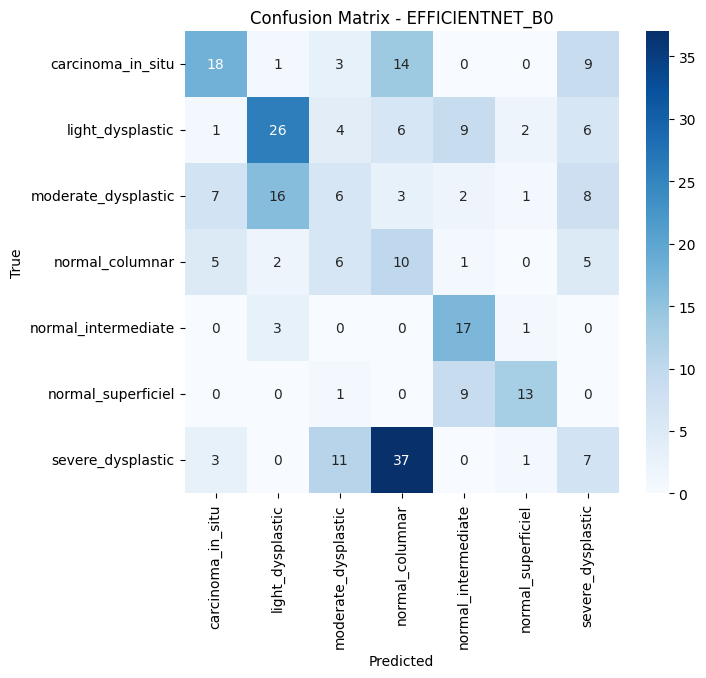


========================= Training CNN_TRANSFORMER =========================
Epoch [01/30] | Train Loss: 1.6171 | Val Loss: 2.5082 | Val Acc: 0.1715
Epoch [02/30] | Train Loss: 1.2995 | Val Loss: 2.2855 | Val Acc: 0.2044
Epoch [03/30] | Train Loss: 1.1234 | Val Loss: 2.1325 | Val Acc: 0.1788
Epoch [04/30] | Train Loss: 1.0359 | Val Loss: 2.1581 | Val Acc: 0.2956
Epoch [05/30] | Train Loss: 0.9742 | Val Loss: 2.2343 | Val Acc: 0.2701
Epoch [06/30] | Train Loss: 0.9045 | Val Loss: 2.2171 | Val Acc: 0.2847
Epoch [07/30] | Train Loss: 0.8229 | Val Loss: 2.7290 | Val Acc: 0.3102
Epoch [08/30] | Train Loss: 0.8212 | Val Loss: 2.7582 | Val Acc: 0.2993
Epoch [09/30] | Train Loss: 0.9121 | Val Loss: 2.4689 | Val Acc: 0.3540
Epoch [10/30] | Train Loss: 0.9429 | Val Loss: 2.4851 | Val Acc: 0.3029
Epoch [11/30] | Train Loss: 0.8149 | Val Loss: 2.9204 | Val Acc: 0.3285
Epoch [12/30] | Train Loss: 0.8125 | Val Loss: 2.4144 | Val Acc: 0.3066
Epoch [13/30] | Train Loss: 0.7339 | Val Loss: 2.7146 | Va

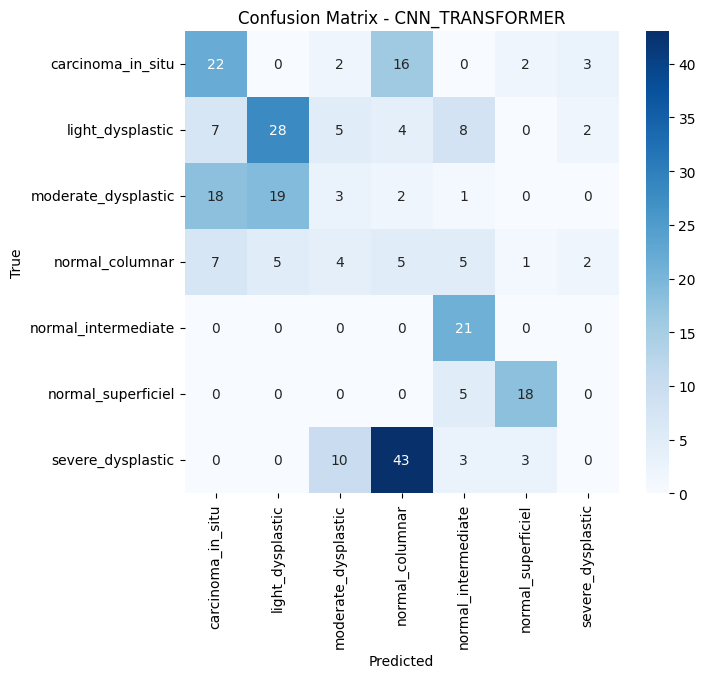

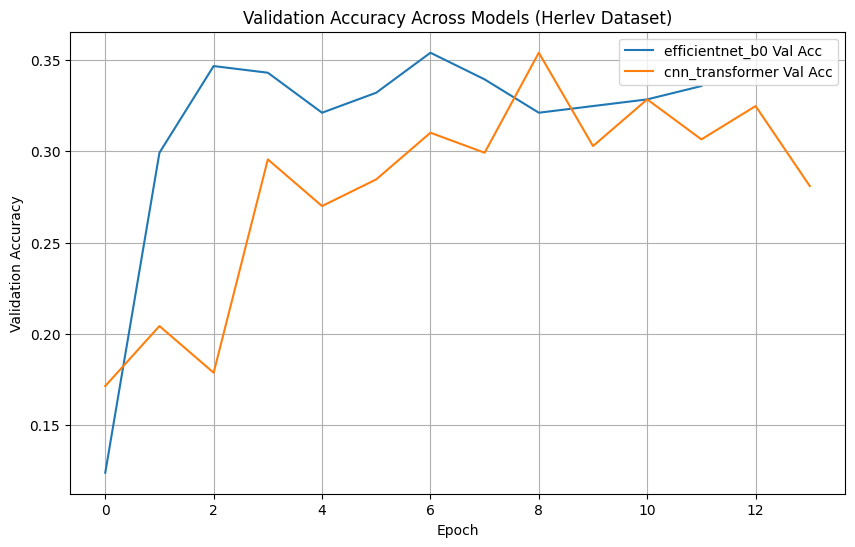

In [6]:
# =========================================
# 🔀 Custom CNN-Transformer Hybrid
# =========================================
class CNNTransformerHybrid(nn.Module):
    """
    A simple hybrid:
      - CNN stem (3 conv blocks) for local texture
      - Flatten → patch embeddings
      - Transformer encoder for global context
      - FC head for classification
    """
    def __init__(self, num_classes=7, embed_dim=256, num_heads=4, num_layers=2):  # ✅ 7 classes
        super(CNNTransformerHybrid, self).__init__()

        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 112×112
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 56×56
            nn.Conv2d(128, embed_dim, 3, padding=1), nn.BatchNorm2d(embed_dim), nn.ReLU(),
            nn.MaxPool2d(4)   # 14×14 feature map
        )

        # Transformer encoder (global context modeling)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True, dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.cnn(x)                    # [B, C, H, W]
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)   # [B, HW, C]
        x = self.transformer(x)            # global contextualization
        x = x.transpose(1, 2)              # [B, C, HW]
        x = self.avgpool(x).squeeze(-1)    # global avg pool
        return self.fc(x)

# =========================================
# 🧱 Training Function (Early Stopping + Save)
# =========================================
def train_model(model, criterion, optimizer, train_loader, test_loader, model_name,
                num_epochs=30, patience=5, save_dir="./models_custom"):
    
    os.makedirs(save_dir, exist_ok=True)
    best_acc, patience_counter = 0.0, 0
    train_losses, val_losses, val_accuracies = [], [], []
    best_model_path = os.path.join(save_dir, f"best_{model_name}.pth")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        val_loss, preds, true_labels = 0.0, [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_loss /= len(test_loader.dataset)
        val_losses.append(val_loss)
        val_acc = accuracy_score(true_labels, preds)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1:02d}/{num_epochs}] | "
              f"Train Loss: {epoch_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⏹️ Early stopping triggered for {model_name}.")
            break

    print(f"💾 Best {model_name} saved to {best_model_path} (Acc: {best_acc:.4f})")
    model.load_state_dict(torch.load(best_model_path))
    return model, train_losses, val_losses, val_accuracies, best_acc


# =========================================
# 🧠 Initialize Models
# =========================================
from timm import create_model

def initialize_model(model_name, num_classes=7):  # ✅ 7 classes for Herlev
    if model_name == "efficientnet_b0":
        model = create_model("efficientnet_b0", pretrained=True, num_classes=num_classes)
    elif model_name == "cnn_transformer":
        model = CNNTransformerHybrid(num_classes=num_classes)
    else:
        raise ValueError("Unknown model name. Choose 'efficientnet_b0' or 'cnn_transformer'.")
    return model.to(device)


# =========================================
# 🚀 Train and Evaluate
# =========================================
models_to_train = ["efficientnet_b0", "cnn_transformer"]
results = {}

# ✅ Updated class names for Herlev dataset
class_names = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

for name in models_to_train:
    print(f"\n{'='*25} Training {name.upper()} {'='*25}")
    model = initialize_model(name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model, train_losses, val_losses, val_accuracies, best_acc = train_model(
        model, criterion, optimizer, train_loader, test_loader,
        model_name=name, num_epochs=30, patience=5
    )

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Final Test Accuracy ({name}): {acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=2))

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[c[:25] for c in class_names],
                yticklabels=[c[:25] for c in class_names])
    plt.title(f"Confusion Matrix - {name.upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    results[name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "best_acc": best_acc
    }

# =========================================
# 📉 Validation Accuracy Curves
# =========================================
plt.figure(figsize=(10,6))
for name, vals in results.items():
    plt.plot(vals["val_accuracies"], label=f'{name} Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Across Models (Herlev Dataset)')
plt.legend()
plt.grid(True)
plt.show()


🔍 Extracting HOG features...


100%|██████████| 643/643 [00:25<00:00, 24.78it/s]


✅ HOG extraction complete: (643, 6084) feature vectors.
🔍 Extracting HOG features...


100%|██████████| 274/274 [00:10<00:00, 25.74it/s]


✅ HOG extraction complete: (274, 6084) feature vectors.
Train HOG feature shape: (643, 6084)
Test HOG feature shape: (274, 6084)
🔍 Extracting HOG features...


100%|██████████| 1/1 [00:00<00:00, 26.45it/s]


✅ HOG extraction complete: (1, 6084) feature vectors, (1, 224, 224) visualization images.


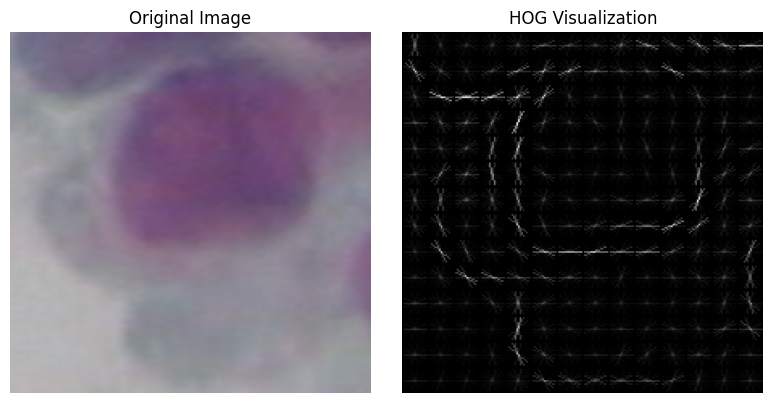


========================= Logistic Regression =========================
✅ Accuracy: 0.2883

📊 Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.38      0.40      0.39        45
   light_dysplastic       0.25      0.31      0.28        54
moderate_dysplastic       0.17      0.19      0.18        43
    normal_columnar       0.31      0.14      0.19        29
normal_intermediate       0.27      0.19      0.22        21
 normal_superficiel       0.50      0.39      0.44        23
  severe_dysplastic       0.30      0.32      0.31        59

           accuracy                           0.29       274
          macro avg       0.31      0.28      0.29       274
       weighted avg       0.30      0.29      0.29       274



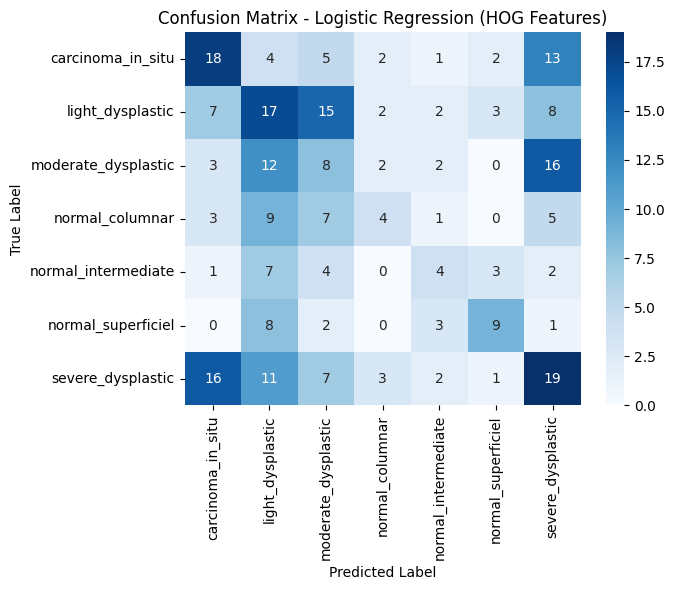


========================= Random Forest =========================
✅ Accuracy: 0.3431

📊 Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.36      0.40      0.38        45
   light_dysplastic       0.41      0.56      0.47        54
moderate_dysplastic       0.14      0.07      0.09        43
    normal_columnar       0.00      0.00      0.00        29
normal_intermediate       0.50      0.14      0.22        21
 normal_superficiel       0.73      0.48      0.58        23
  severe_dysplastic       0.27      0.49      0.35        59

           accuracy                           0.34       274
          macro avg       0.35      0.31      0.30       274
       weighted avg       0.32      0.34      0.31       274



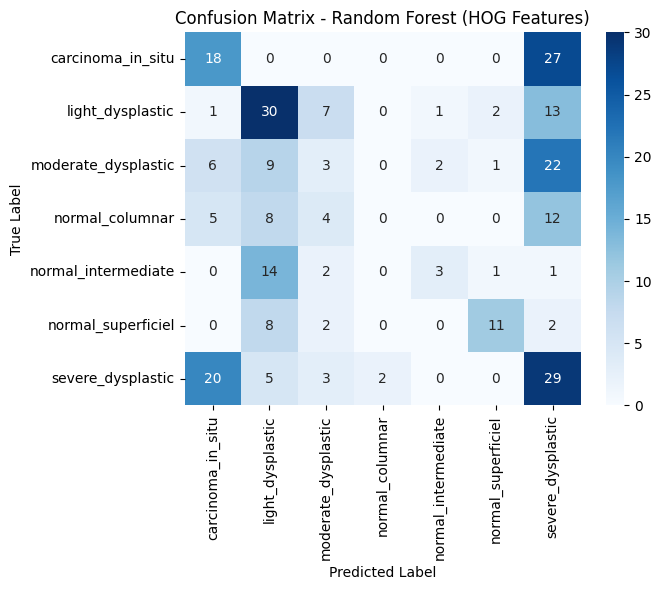


========================= Linear SVM =========================
✅ Accuracy: 0.2299

📊 Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.31      0.33      0.32        45
   light_dysplastic       0.25      0.28      0.26        54
moderate_dysplastic       0.12      0.14      0.13        43
    normal_columnar       0.12      0.07      0.09        29
normal_intermediate       0.21      0.24      0.22        21
 normal_superficiel       0.35      0.35      0.35        23
  severe_dysplastic       0.24      0.20      0.22        59

           accuracy                           0.23       274
          macro avg       0.23      0.23      0.23       274
       weighted avg       0.23      0.23      0.23       274



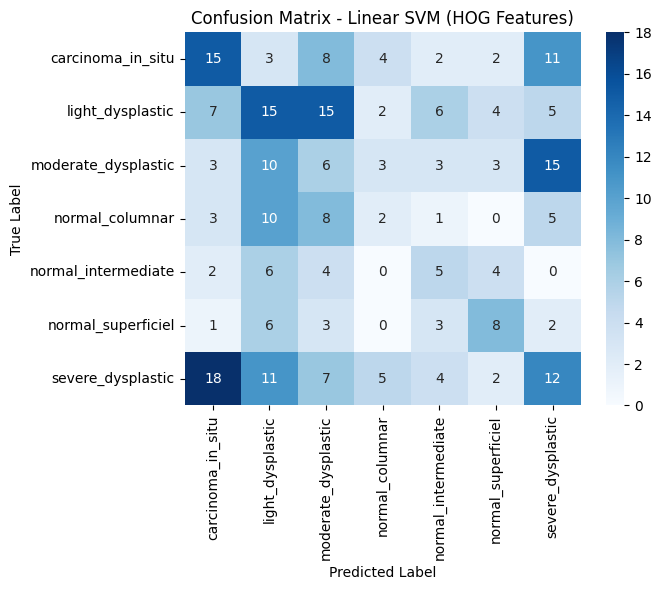

In [7]:
# =========================================
# 📦 Imports
# =========================================
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# =========================================
# ⚙️ HOG Feature Extraction (fixed for channel-first tensors)
# =========================================
def extract_hog_features(images, visualize=False):
    """
    Extract HOG features for Herlev dataset images.
    Automatically handles channel-first or channel-last images.
    """
    hog_features, hog_images = [], []
    print("🔍 Extracting HOG features...")

    for img in tqdm(images):
        # Convert from tensor (C, H, W) or numpy channel-first to (H, W, C)
        if img.ndim == 3 and img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))  # ✅ Fix shape to (H, W, 3)

        gray = rgb2gray(img)
        gray = np.clip(gray, 0, 1)

        feature, hog_image = hog(
            gray,
            orientations=9,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=True,
            feature_vector=True
        )
        hog_features.append(feature)
        if visualize:
            hog_images.append(hog_image)

    hog_features = np.array(hog_features)
    if visualize:
        hog_images = np.array(hog_images)
        print(f"✅ HOG extraction complete: {hog_features.shape} feature vectors, "
              f"{hog_images.shape} visualization images.")
        return hog_features, hog_images
    else:
        print(f"✅ HOG extraction complete: {hog_features.shape} feature vectors.")
        return hog_features


# =========================================
# 🚀 Apply HOG Extraction (Train/Test)
# =========================================
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

print(f"Train HOG feature shape: {X_train_hog.shape}")
print(f"Test HOG feature shape: {X_test_hog.shape}")

# Optional — visualize one example
_, X_train_hog_viz = extract_hog_features(X_train[:1], visualize=True)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.transpose(X_train[0], (1, 2, 0)))  # ✅ Fixed channel order
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(X_train_hog_viz[0], cmap="gray")
plt.title("HOG Visualization")
plt.axis("off")
plt.tight_layout()
plt.show()

# =========================================
# 🧠 Define ML Models
# =========================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=300, solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVM": LinearSVC(max_iter=5000, random_state=42)
}

trained_models = {}

# ✅ Herlev class names
class_names = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

# =========================================
# 🚀 Train and Evaluate
# =========================================
for name, model in models.items():
    print(f"\n{'='*25} {name} {'='*25}")
    model.fit(X_train_hog, y_train)
    y_pred = model.predict(X_test_hog)

    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=2))

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[c[:25] for c in class_names],
                yticklabels=[c[:25] for c in class_names])
    plt.title(f"Confusion Matrix - {name} (HOG Features)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    trained_models[name] = model


In [8]:
# =========================================
# 🧭 Unified HOG Feature Importance Visualization (All Models – Herlev Dataset)
# =========================================
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import os, zipfile

# =========================================
# ⚙️ HOG Importance Visualization Function
# =========================================
def visualize_hog_importance_for_class(model, model_name, class_idx, class_name, image,
                                       orientations=9, pixels_per_cell=(16,16),
                                       cells_per_block=(2,2), output_dir="./hog_importance_maps"):
    """
    Visualize and save HOG-based importance heatmap for a given class.
    Works with Logistic Regression, Linear SVM, Random Forest.
    Saves both HOG + importance overlay for that class.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Ensure image is in (H, W, 3)
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))

    gray = rgb2gray(image)

    # Compute HOG on the image
    feature, hog_image = hog(
        gray,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )

    # Expected spatial shape of the HOG cell grid
    n_cells_y = gray.shape[0] // pixels_per_cell[0]
    n_cells_x = gray.shape[1] // pixels_per_cell[1]
    spatial_shape = (n_cells_y - cells_per_block[0] + 1,
                     n_cells_x - cells_per_block[1] + 1,
                     orientations)
    expected_size = np.prod(spatial_shape)

    # =============================
    # 🔍 Model-specific importance extraction
    # =============================
    if model_name in ["Logistic Regression", "Linear SVM"]:
        coef = model.coef_[class_idx]
        if coef.size != expected_size:
            print(f"[⚠️] {model_name} ({class_name}) shape mismatch: expected {expected_size}, got {coef.size}. Adjusting.")
            n_cells_total = coef.size // orientations
            n_side = int(np.sqrt(n_cells_total))
            spatial_shape = (n_side, n_side, orientations)
        importance_map = np.abs(coef).reshape(spatial_shape).sum(axis=2)

    elif model_name == "Random Forest":
        importance = model.feature_importances_
        if importance.size != expected_size:
            print(f"[⚠️] Random Forest ({class_name}) shape mismatch: expected {expected_size}, got {importance.size}. Adjusting.")
            n_cells_total = importance.size // orientations
            n_side = int(np.sqrt(n_cells_total))
            spatial_shape = (n_side, n_side, orientations)
        importance_map = np.abs(importance).reshape(spatial_shape).sum(axis=2)

    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    # =============================
    # 🔧 Normalize and upscale
    # =============================
    importance_map = exposure.rescale_intensity(importance_map, in_range='image', out_range=(0, 1))
    importance_map_resized = np.kron(importance_map, np.ones(pixels_per_cell))

    # =============================
    # 🖼️ Visualization
    # =============================
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original ({class_name})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.imshow(importance_map_resized, cmap='jet', alpha=0.45)
    plt.title(f"HOG Importance\n{model_name} ({class_name})")
    plt.axis("off")

    plt.tight_layout()

    # Save the overlay image
    save_path = os.path.join(output_dir, f"{model_name.replace(' ', '_')}_{class_name.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()

    print(f"✅ Saved: {save_path}")


# =========================================
# 📋 Class Names (Herlev Dataset – 7 Classes)
# =========================================
class_names = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

output_dir = "./hog_importance_maps"
os.makedirs(output_dir, exist_ok=True)

# =========================================
# 🔄 Generate Heatmaps for All Models + Classes
# =========================================
# Combine train and test to pick representative images
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

for model_name, model in trained_models.items():
    print(f"\n=== Generating HOG XAI Heatmaps for {model_name} ===")
    for class_idx, cname in enumerate(class_names):
        # Pick one representative image from that class
        idx_candidates = np.where(y_all == class_idx)[0]
        if len(idx_candidates) == 0:
            print(f"[⚠️] No samples found for {cname}. Skipping.")
            continue
        img_idx = idx_candidates[0]
        visualize_hog_importance_for_class(
            model, model_name, class_idx, cname, X_all[img_idx],
            orientations=9,
            pixels_per_cell=(16,16),
            cells_per_block=(2,2),
            output_dir=output_dir
        )

# =========================================
# 📦 Create ZIP file for download
# =========================================
zip_filename = "hog_importance_maps.zip"
zip_path = os.path.join(".", zip_filename)

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=os.path.relpath(file_path, output_dir))

print(f"\n📦 All HOG importance maps saved and zipped → {zip_path}")
print("✅ You can now download the ZIP file directly from the working directory.")



=== Generating HOG XAI Heatmaps for Logistic Regression ===
[⚠️] Logistic Regression (carcinoma_in_situ) shape mismatch: expected 1521, got 6084. Adjusting.
✅ Saved: ./hog_importance_maps/Logistic_Regression_carcinoma_in_situ.png
[⚠️] Logistic Regression (light_dysplastic) shape mismatch: expected 1521, got 6084. Adjusting.
✅ Saved: ./hog_importance_maps/Logistic_Regression_light_dysplastic.png
[⚠️] Logistic Regression (moderate_dysplastic) shape mismatch: expected 1521, got 6084. Adjusting.
✅ Saved: ./hog_importance_maps/Logistic_Regression_moderate_dysplastic.png
[⚠️] Logistic Regression (normal_columnar) shape mismatch: expected 1521, got 6084. Adjusting.
✅ Saved: ./hog_importance_maps/Logistic_Regression_normal_columnar.png
[⚠️] Logistic Regression (normal_intermediate) shape mismatch: expected 1521, got 6084. Adjusting.
✅ Saved: ./hog_importance_maps/Logistic_Regression_normal_intermediate.png
[⚠️] Logistic Regression (normal_superficiel) shape mismatch: expected 1521, got 6084. 

🔍 Extracting LBP features...


  0%|          | 0/643 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 643/643 [00:07<00:00, 91.01it/s]


✅ LBP extraction complete: (643, 10) features.
🔍 Extracting LBP features...


100%|██████████| 274/274 [00:02<00:00, 91.94it/s]


✅ LBP extraction complete: (274, 10) features.
Train LBP feature shape: (643, 10)
Test LBP feature shape: (274, 10)
🔍 Extracting LBP features...


100%|██████████| 1/1 [00:00<00:00, 84.50it/s]


✅ LBP extraction complete: (1, 10) features, (1, 224, 224) images.


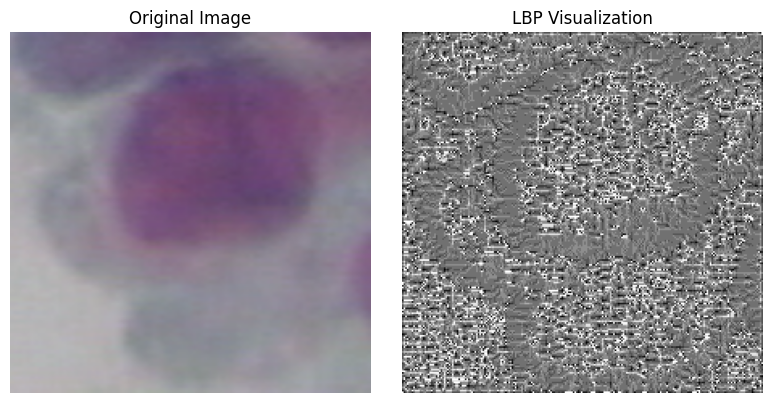


========================= Logistic Regression (LBP) =========================
✅ Accuracy: 0.3686

📊 Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.00      0.00      0.00        45
   light_dysplastic       0.43      0.76      0.55        54
moderate_dysplastic       0.00      0.00      0.00        43
    normal_columnar       0.00      0.00      0.00        29
normal_intermediate       0.00      0.00      0.00        21
 normal_superficiel       0.67      0.09      0.15        23
  severe_dysplastic       0.33      0.98      0.49        59

           accuracy                           0.37       274
          macro avg       0.20      0.26      0.17       274
       weighted avg       0.21      0.37      0.23       274



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


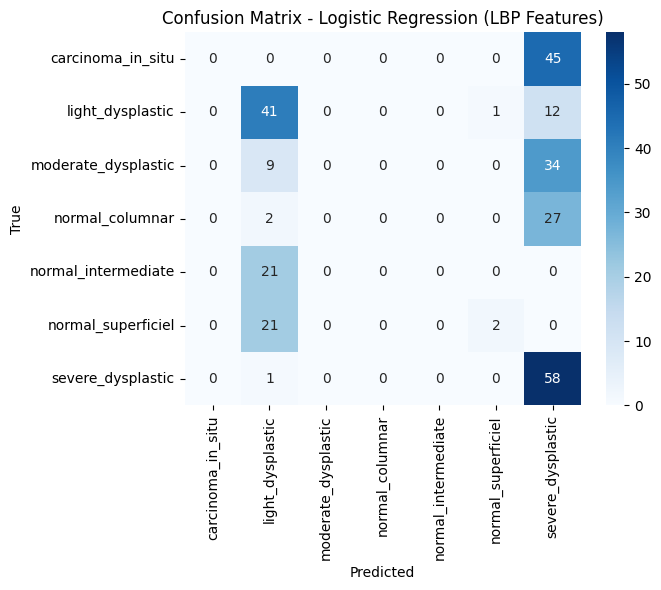


========================= Random Forest (LBP) =========================
✅ Accuracy: 0.3175

📊 Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.50      0.20      0.29        45
   light_dysplastic       0.53      0.50      0.51        54
moderate_dysplastic       0.40      0.33      0.36        43
    normal_columnar       0.07      0.17      0.10        29
normal_intermediate       0.52      0.67      0.58        21
 normal_superficiel       0.40      0.43      0.42        23
  severe_dysplastic       0.19      0.14      0.16        59

           accuracy                           0.32       274
          macro avg       0.37      0.35      0.34       274
       weighted avg       0.37      0.32      0.33       274



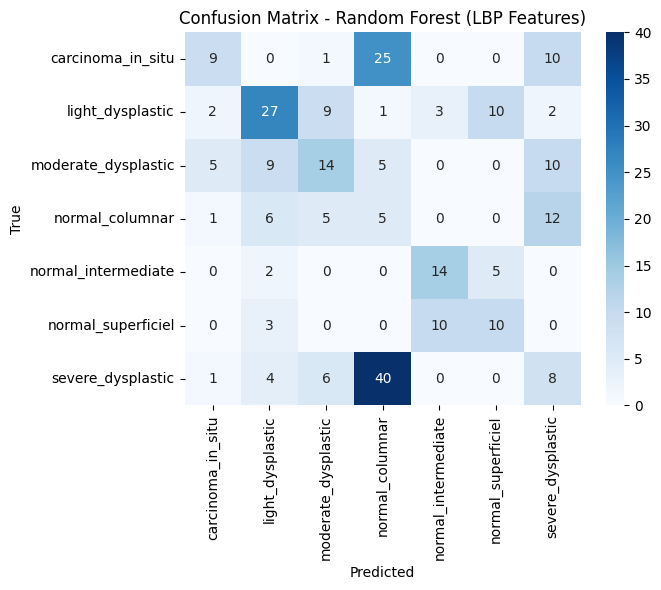


========================= Linear SVM (LBP) =========================
✅ Accuracy: 0.3175

📊 Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.00      0.00      0.00        45
   light_dysplastic       0.56      0.61      0.58        54
moderate_dysplastic       0.00      0.00      0.00        43
    normal_columnar       0.08      0.10      0.09        29
normal_intermediate       0.00      0.00      0.00        21
 normal_superficiel       0.43      0.83      0.57        23
  severe_dysplastic       0.24      0.54      0.34        59

           accuracy                           0.32       274
          macro avg       0.19      0.30      0.23       274
       weighted avg       0.21      0.32      0.24       274



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


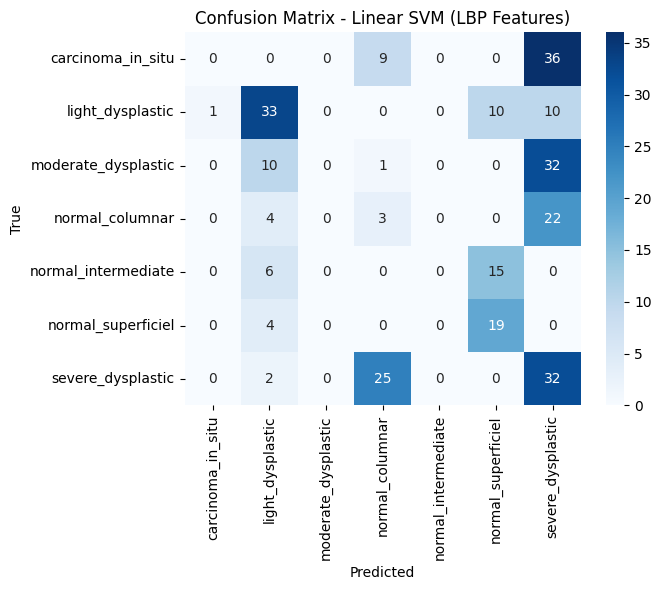

In [9]:
# =========================================
# 📦 Imports
# =========================================
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# =========================================
# ⚙️ LBP Feature Extraction (Herlev compatible)
# =========================================
def extract_lbp_features(images, P=8, R=1, method='uniform', visualize=False):
    """
    Extract Local Binary Pattern (LBP) histograms for each image.
    Automatically handles channel-first or channel-last images.

    Args:
        images : numpy array (N, H, W, 3) or (N, 3, H, W)
        P : number of circularly symmetric neighbor set points
        R : radius of circle
        method : 'uniform' for rotation-invariant binary patterns
        visualize : if True, returns both LBP histograms and images
    Returns:
        features : (N, P+2) array of normalized LBP histograms
        lbp_images : (optional) array of LBP visual maps
    """
    lbp_features, lbp_images = [], []
    print("🔍 Extracting LBP features...")

    for img in tqdm(images):
        # Convert from (3, H, W) to (H, W, 3) if necessary
        if img.ndim == 3 and img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))

        gray = rgb2gray(img)
        lbp = local_binary_pattern(gray, P, R, method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # normalize histogram

        lbp_features.append(hist)
        if visualize:
            lbp_images.append(lbp)

    lbp_features = np.array(lbp_features)
    if visualize:
        lbp_images = np.array(lbp_images)
        print(f"✅ LBP extraction complete: {lbp_features.shape} features, {lbp_images.shape} images.")
        return lbp_features, lbp_images
    else:
        print(f"✅ LBP extraction complete: {lbp_features.shape} features.")
        return lbp_features


# =========================================
# 🚀 Apply LBP Extraction (Train/Test)
# =========================================
X_train_lbp = extract_lbp_features(X_train)
X_test_lbp = extract_lbp_features(X_test)

print(f"Train LBP feature shape: {X_train_lbp.shape}")
print(f"Test LBP feature shape: {X_test_lbp.shape}")

# Optional — visualize one example
_, X_train_lbp_viz = extract_lbp_features(X_train[:1], visualize=True)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.transpose(X_train[0], (1, 2, 0)))  # ✅ Fix channel order for visualization
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(X_train_lbp_viz[0], cmap="gray")
plt.title("LBP Visualization")
plt.axis("off")
plt.tight_layout()
plt.show()


# =========================================
# 🧠 Define Models
# =========================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=300, solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVM": LinearSVC(max_iter=5000, random_state=42)
}

trained_models_lbp = {}

# ✅ Herlev class names
class_names = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

# =========================================
# 🚀 Training and Evaluation
# =========================================
for name, model in models.items():
    print(f"\n{'='*25} {name} (LBP) {'='*25}")
    model.fit(X_train_lbp, y_train)
    y_pred = model.predict(X_test_lbp)

    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=2))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[c[:25] for c in class_names],
                yticklabels=[c[:25] for c in class_names])
    plt.title(f"Confusion Matrix - {name} (LBP Features)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    trained_models_lbp[name] = model


In [10]:
# =========================================
# 🧭 Unified LBP Feature Importance Visualization (All Models – Herlev Dataset)
# =========================================
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import zipfile

def visualize_lbp_importance_for_class(model, model_name, class_idx, class_name,
                                       image, lbp_image, P=8, output_dir="./lbp_importance_maps"):
    """
    Visualize class-specific LBP feature importance for Logistic Regression,
    Linear SVM, and Random Forest classifiers.
    Generates and saves overlay heatmaps combining LBP patterns with learned importance.
    """
    os.makedirs(output_dir, exist_ok=True)

    # =====================================
    # Model-specific importance
    # =====================================
    if model_name in ["Logistic Regression", "Linear SVM"]:
        coef = model.coef_[class_idx]
        importance = np.abs(coef)
    elif model_name == "Random Forest":
        importance = model.feature_importances_
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    # Normalize importance values between 0–1
    importance = exposure.rescale_intensity(importance, in_range='image', out_range=(0, 1))

    # =====================================
    # Build importance mask (per LBP bin)
    # =====================================
    importance_mask = np.zeros_like(lbp_image, dtype=float)
    for b in range(len(importance)):
        importance_mask[lbp_image == b] = importance[b]

    # =====================================
    # Visualization setup
    # =====================================
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))  # Convert (3,H,W) → (H,W,3)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original ({class_name})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(lbp_image, cmap='gray')
    plt.imshow(importance_mask, cmap='jet', alpha=0.45)
    plt.title(f"LBP Importance\n{model_name} ({class_name})")
    plt.axis("off")

    plt.tight_layout()

    # Save image
    save_path = os.path.join(output_dir, f"{model_name.replace(' ', '_')}_{class_name.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Saved LBP heatmap for {model_name} ({class_name}) → {save_path}")


# =========================================
# 📋 Herlev Class Names (7 Classes)
# =========================================
class_names = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

output_dir = "./lbp_importance_maps"
os.makedirs(output_dir, exist_ok=True)

# =========================================
# 🔄 Generate LBP XAI Heatmaps for All Models + Classes
# =========================================
# Combine train and test for representative samples
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# Generate LBP visual maps for all combined samples
_, X_all_lbp_viz = extract_lbp_features(X_all, visualize=True)

for model_name, model in trained_models_lbp.items():
    print(f"\n=== Generating LBP XAI Heatmaps for {model_name} ===")
    for class_idx, cname in enumerate(class_names):
        # Pick one representative image from the class
        idx_candidates = np.where(y_all == class_idx)[0]
        if len(idx_candidates) == 0:
            print(f"[⚠️] No samples found for {cname}. Skipping.")
            continue

        img_idx = idx_candidates[0]
        visualize_lbp_importance_for_class(
            model, model_name, class_idx, cname,
            X_all[img_idx], X_all_lbp_viz[img_idx],
            P=8, output_dir=output_dir
        )

# =========================================
# 📦 Create ZIP File for All LBP Heatmaps
# =========================================
zip_filename = "lbp_importance_maps.zip"
zip_path = os.path.join(".", zip_filename)

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=os.path.relpath(file_path, output_dir))

print(f"\n📦 All LBP importance maps saved and zipped → {zip_path}")
print("✅ You can now download the ZIP file directly from the working directory.")


🔍 Extracting LBP features...


  0%|          | 0/917 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 917/917 [00:09<00:00, 92.38it/s]


✅ LBP extraction complete: (917, 10) features, (917, 224, 224) images.

=== Generating LBP XAI Heatmaps for Logistic Regression ===
✅ Saved LBP heatmap for Logistic Regression (carcinoma_in_situ) → ./lbp_importance_maps/Logistic_Regression_carcinoma_in_situ.png
✅ Saved LBP heatmap for Logistic Regression (light_dysplastic) → ./lbp_importance_maps/Logistic_Regression_light_dysplastic.png
✅ Saved LBP heatmap for Logistic Regression (moderate_dysplastic) → ./lbp_importance_maps/Logistic_Regression_moderate_dysplastic.png
✅ Saved LBP heatmap for Logistic Regression (normal_columnar) → ./lbp_importance_maps/Logistic_Regression_normal_columnar.png
✅ Saved LBP heatmap for Logistic Regression (normal_intermediate) → ./lbp_importance_maps/Logistic_Regression_normal_intermediate.png
✅ Saved LBP heatmap for Logistic Regression (normal_superficiel) → ./lbp_importance_maps/Logistic_Regression_normal_superficiel.png
✅ Saved LBP heatmap for Logistic Regression (severe_dysplastic) → ./lbp_importance_m

🔍 Extracting SIFT descriptors...


100%|██████████| 643/643 [00:08<00:00, 72.80it/s]


✅ Extracted total descriptors: (16692, 128)
🔍 Extracting SIFT descriptors...


100%|██████████| 274/274 [00:03<00:00, 71.52it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


✅ Extracted total descriptors: (11570, 128)
✅ Combined descriptor matrix shape: (28262, 128)
🔧 Clustering 28262 descriptors into 150 visual words...


100%|██████████| 274/274 [00:00<00:00, 2531.67it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


✅ Train SIFT-BoVW feature shape: (643, 150)
✅ Test SIFT-BoVW feature shape: (274, 150)

========================= Logistic Regression (SIFT-BoVW) =========================
✅ Accuracy: 0.2299

📊 Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.44      0.16      0.23        45
   light_dysplastic       0.20      0.67      0.31        54
moderate_dysplastic       0.00      0.00      0.00        43
    normal_columnar       0.00      0.00      0.00        29
normal_intermediate       0.00      0.00      0.00        21
 normal_superficiel       0.00      0.00      0.00        23
  severe_dysplastic       0.26      0.34      0.30        59

           accuracy                           0.23       274
          macro avg       0.13      0.17      0.12       274
       weighted avg       0.17      0.23      0.16       274



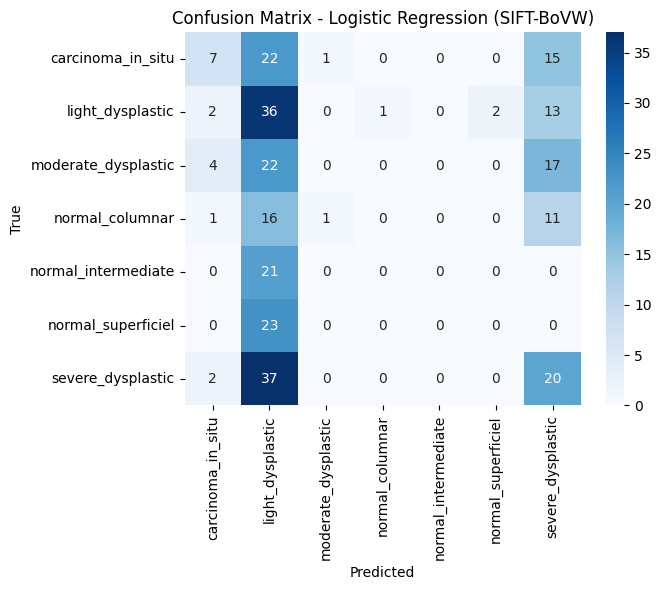


========================= Random Forest (SIFT-BoVW) =========================
✅ Accuracy: 0.2482

📊 Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.33      0.29      0.31        45
   light_dysplastic       0.24      0.37      0.29        54
moderate_dysplastic       0.02      0.02      0.02        43
    normal_columnar       0.00      0.00      0.00        29
normal_intermediate       0.41      0.57      0.48        21
 normal_superficiel       0.54      0.30      0.39        23
  severe_dysplastic       0.26      0.25      0.26        59

           accuracy                           0.25       274
          macro avg       0.26      0.26      0.25       274
       weighted avg       0.24      0.25      0.24       274



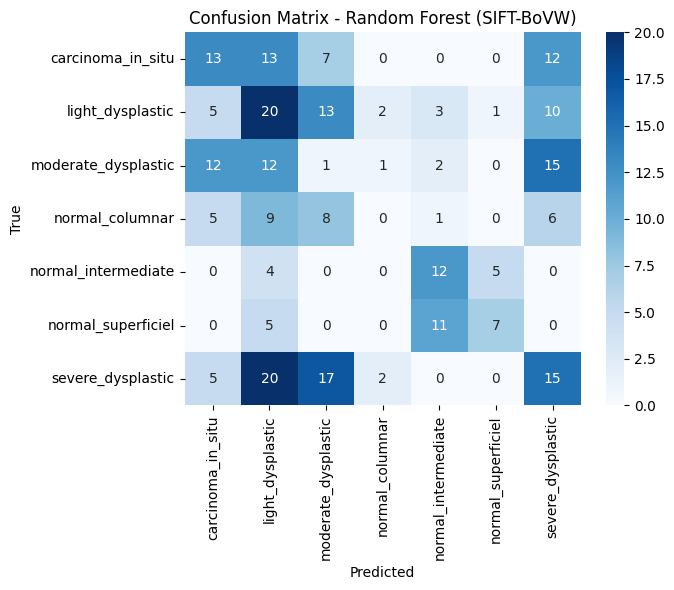


========================= Linear SVM (SIFT-BoVW) =========================
✅ Accuracy: 0.2080

📊 Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.35      0.24      0.29        45
   light_dysplastic       0.18      0.33      0.24        54
moderate_dysplastic       0.09      0.12      0.10        43
    normal_columnar       0.29      0.07      0.11        29
normal_intermediate       0.18      0.14      0.16        21
 normal_superficiel       0.29      0.17      0.22        23
  severe_dysplastic       0.29      0.24      0.26        59

           accuracy                           0.21       274
          macro avg       0.24      0.19      0.20       274
       weighted avg       0.24      0.21      0.21       274



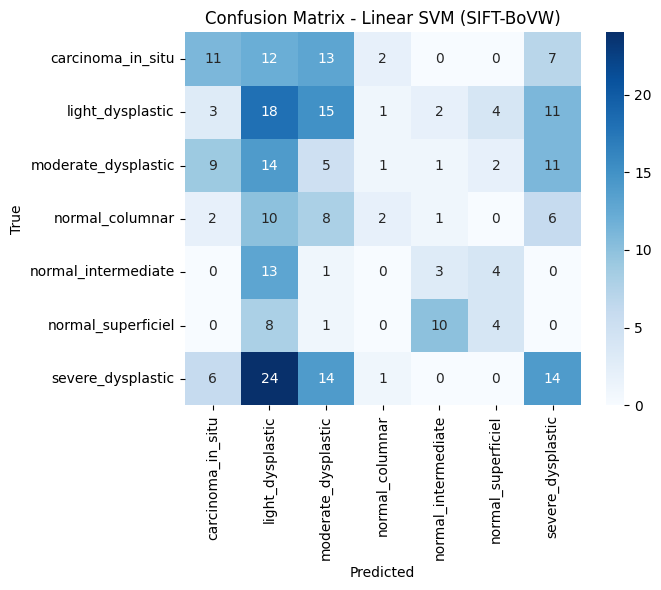

In [11]:
# =========================================
# 📦 Imports
# =========================================
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# =========================================
# ⚙️ Step 1: Extract SIFT descriptors (Fixed for PyTorch tensors)
# =========================================
def extract_sift_descriptors(images, n_features=400):
    """
    Extract SIFT descriptors from all images (supports both tensors and numpy arrays).
    Returns:
        all_descriptors: stacked array of all descriptors
        image_descriptors: list of descriptors per image
    """
    sift = cv2.SIFT_create(nfeatures=n_features)
    all_descriptors = []
    image_descriptors = []

    print("🔍 Extracting SIFT descriptors...")
    for img in tqdm(images):
        # ✅ Convert from tensor → numpy if needed
        if hasattr(img, "detach"):
            img = img.detach().cpu().numpy()

        # ✅ Convert from (3, H, W) → (H, W, 3)
        if img.ndim == 3 and img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))

        # ✅ Ensure valid data range and dtype
        img = np.clip(img * 255, 0, 255).astype("uint8") if img.max() <= 1 else img.astype("uint8")

        # Convert to grayscale for SIFT
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Compute SIFT keypoints and descriptors
        kp, des = sift.detectAndCompute(gray, None)
        if des is not None:
            des = des.astype(np.float32)
            all_descriptors.append(des)
            image_descriptors.append(des)
        else:
            # Fallback for images with no detected features
            image_descriptors.append(np.zeros((1, 128), dtype=np.float32))

    if len(all_descriptors) > 0:
        all_descriptors = np.vstack(all_descriptors)
    else:
        all_descriptors = np.zeros((1, 128), dtype=np.float32)

    print(f"✅ Extracted total descriptors: {all_descriptors.shape}")
    return all_descriptors, image_descriptors
# =========================================
# 🚀 Extract SIFT Descriptors (Train + Test)
# =========================================
all_des_train, img_des_train = extract_sift_descriptors(X_train)
all_des_test, img_des_test = extract_sift_descriptors(X_test)

# Combine both sets to build global vocabulary
all_des = np.vstack([all_des_train, all_des_test])
print("✅ Combined descriptor matrix shape:", all_des.shape)

# =========================================
# ⚙️ Step 2: Build Codebook (KMeans) and BoVW Features
# =========================================
k = 150  # Number of visual words (tunable)
print(f"🔧 Clustering {len(all_des)} descriptors into {k} visual words...")
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
kmeans.fit(all_des)

def build_bovw_features(image_des_list, kmeans):
    """
    Convert list of SIFT descriptors into normalized BoVW histograms.
    """
    bovw_features = []
    for des in tqdm(image_des_list):
        if des is None or len(des) == 0:
            hist = np.zeros(kmeans.n_clusters)
        else:
            des = des.astype(np.float32)
            words = kmeans.predict(des)
            hist, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6)  # normalize histogram
        bovw_features.append(hist)
    return np.array(bovw_features)


# =========================================
# 🧠 Create BoVW Feature Vectors
# =========================================
X_train_sift = build_bovw_features(img_des_train, kmeans)
X_test_sift = build_bovw_features(img_des_test, kmeans)

print(f"✅ Train SIFT-BoVW feature shape: {X_train_sift.shape}")
print(f"✅ Test SIFT-BoVW feature shape: {X_test_sift.shape}")

# =========================================
# 🧠 Define Models
# =========================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVM": LinearSVC(max_iter=5000, random_state=42)
}

# =========================================
# 📋 Herlev Class Names
# =========================================
class_names = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

# =========================================
# 🚀 Training and Evaluation
# =========================================
trained_models_sift = {}

for name, model in models.items():
    print(f"\n{'='*25} {name} (SIFT-BoVW) {'='*25}")
    model.fit(X_train_sift, y_train)
    y_pred = model.predict(X_test_sift)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=2))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[c[:25] for c in class_names],
                yticklabels=[c[:25] for c in class_names])
    plt.title(f"Confusion Matrix - {name} (SIFT-BoVW)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    trained_models_sift[name] = model


In [12]:
# =========================================
# 🧭  SIFT Keypoint Importance Visualization (XAI) — Final Fixed Version
# =========================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile

def visualize_sift_importance(model, model_name, class_idx, class_name,
                              image, kmeans, n_top=15, output_dir="./sift_importance_maps"):
    """
    Visualize class-specific SIFT keypoints with highest model importance.
    Shows side-by-side: Original | Importance Overlay.
    Supports Logistic Regression, Linear SVM, and Random Forest models.
    """
    os.makedirs(output_dir, exist_ok=True)

    # ✅ Convert from tensor → numpy if needed
    if hasattr(image, "detach"):
        image = image.detach().cpu().numpy()

    # ✅ Convert from (3, H, W) → (H, W, 3)
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))

    # ✅ Convert to uint8 for OpenCV
    if image.dtype != np.uint8:
        if image.max() <= 1.0:
            image_uint8 = (image * 255).astype('uint8')
        else:
            image_uint8 = np.clip(image, 0, 255).astype('uint8')
    else:
        image_uint8 = image.copy()

    # =========================================
    # Extract SIFT descriptors
    # =========================================
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
    kp, des = sift.detectAndCompute(gray, None)

    if des is None or len(kp) == 0:
        print(f"[⚠️] No SIFT keypoints found for {class_name}")
        return

    # ✅ Convert descriptors to float32 (match KMeans dtype)
    des = des.astype(np.float32)

    # Predict cluster assignments (visual words)
    word_ids = kmeans.predict(des)

    # =========================================
    # Retrieve model-specific importance weights
    # =========================================
    if model_name in ["Logistic Regression", "Linear SVM"]:
        weights = np.abs(model.coef_[class_idx])
    elif model_name == "Random Forest":
        weights = model.feature_importances_
    else:
        raise ValueError("Unsupported model type.")

    # Assign each keypoint a weight from its corresponding visual word
    kp_weights = np.array([weights[w] for w in word_ids])

    # Select top-N keypoints by importance
    top_idx = np.argsort(kp_weights)[-n_top:]
    top_kp = [kp[i] for i in top_idx]

    # =========================================
    # Draw top keypoints
    # =========================================
    out_img = cv2.drawKeypoints(
        image_uint8, top_kp, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        color=(255, 0, 0)  # Red = most important
    )

    # =========================================
    # Visualization
    # =========================================
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_uint8)
    plt.title(f"Original Image ({class_name})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(out_img)
    plt.title(f"SIFT Importance Map\n{model_name} ({class_name})")
    plt.axis("off")

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"{model_name.replace(' ', '_')}_{class_name.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()

    print(f"✅ Saved SIFT importance map for {model_name} ({class_name}) → {save_path}")


# =========================================
# 📋 Herlev Class Names (7 Classes)
# =========================================
class_names = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

output_dir = "./sift_importance_maps"
os.makedirs(output_dir, exist_ok=True)

# =========================================
# 🔄 Generate Side-by-Side SIFT Maps for All Models + Classes
# =========================================
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

for model_name, model in trained_models_sift.items():
    print(f"\n=== Generating SIFT XAI Heatmaps for {model_name} ===")
    for class_idx, cname in enumerate(class_names):
        idx_candidates = np.where(y_all == class_idx)[0]
        if len(idx_candidates) == 0:
            print(f"[⚠️] No samples found for {cname}. Skipping.")
            continue

        img_idx = idx_candidates[0]
        visualize_sift_importance(
            model, model_name, class_idx, cname,
            X_all[img_idx], kmeans, n_top=15,
            output_dir=output_dir
        )

# =========================================
# 📦 Create ZIP file for All SIFT Visualizations
# =========================================
zip_filename = "sift_importance_maps.zip"
zip_path = os.path.join(".", zip_filename)

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=os.path.relpath(file_path, output_dir))

print(f"\n📦 All SIFT importance maps saved and zipped → {zip_path}")
print("✅ You can now download the ZIP file directly from your working directory.")



=== Generating SIFT XAI Heatmaps for Logistic Regression ===
✅ Saved SIFT importance map for Logistic Regression (carcinoma_in_situ) → ./sift_importance_maps/Logistic_Regression_carcinoma_in_situ.png
✅ Saved SIFT importance map for Logistic Regression (light_dysplastic) → ./sift_importance_maps/Logistic_Regression_light_dysplastic.png
✅ Saved SIFT importance map for Logistic Regression (moderate_dysplastic) → ./sift_importance_maps/Logistic_Regression_moderate_dysplastic.png
✅ Saved SIFT importance map for Logistic Regression (normal_columnar) → ./sift_importance_maps/Logistic_Regression_normal_columnar.png
✅ Saved SIFT importance map for Logistic Regression (normal_intermediate) → ./sift_importance_maps/Logistic_Regression_normal_intermediate.png
✅ Saved SIFT importance map for Logistic Regression (normal_superficiel) → ./sift_importance_maps/Logistic_Regression_normal_superficiel.png
✅ Saved SIFT importance map for Logistic Regression (severe_dysplastic) → ./sift_importance_maps/Log

In [13]:
# =========================================
# 📦 Imports
# =========================================
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import timm
import matplotlib.pyplot as plt
import zipfile

# =========================================
# ⚙️ Device
# =========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =========================================
# 🔀 Custom CNN-Transformer Hybrid
# =========================================
class CNNTransformerHybrid(nn.Module):
    def __init__(self, num_classes=7, embed_dim=256, num_heads=4, num_layers=2):
        super(CNNTransformerHybrid, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, embed_dim, 3, padding=1), nn.BatchNorm2d(embed_dim), nn.ReLU(),
            nn.MaxPool2d(4)
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True, dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.transformer(x)
        x = x.transpose(1, 2)
        x = self.avgpool(x).squeeze(-1)
        return self.fc(x)

# =========================================
# 🧠 Load Trained Models (Herlev)
# =========================================
num_classes = 7
model_paths = {
    "AlexNet": "/kaggle/input/herlev-dataset-dl-models/pytorch/default/1/best_alexnet.pth",
    "ResNet50": "/kaggle/input/herlev-dataset-dl-models/pytorch/default/1/best_resnet50.pth",
    "CNN-Transformer": "/kaggle/input/herlev-dataset-dl-models/pytorch/default/1/best_cnn_transformer.pth",
    "EfficientNetB0": "/kaggle/input/herlev-dataset-dl-models/pytorch/default/1/best_efficientnet_b0.pth"
}

# --- AlexNet ---
alexnet_model = models.alexnet(weights=None)
alexnet_model.classifier[6] = nn.Linear(4096, num_classes)
alexnet_model.load_state_dict(torch.load(model_paths["AlexNet"], map_location=device))
alexnet_model.eval().to(device)

# --- ResNet50 ---
resnet_model = models.resnet50(weights=None)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model.load_state_dict(torch.load(model_paths["ResNet50"], map_location=device))
resnet_model.eval().to(device)

# --- EfficientNetB0 ---
efficientnet_model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes)
efficientnet_model.load_state_dict(torch.load(model_paths["EfficientNetB0"], map_location=device), strict=False)
efficientnet_model.eval().to(device)

# --- CNN-Transformer ---
cnn_transformer_model = CNNTransformerHybrid(num_classes=num_classes)
cnn_transformer_model.load_state_dict(torch.load(model_paths["CNN-Transformer"], map_location=device))
cnn_transformer_model.eval().to(device)

# =========================================
# 🎯 Target Layers for Grad-CAM
# =========================================
target_layers = {
    "AlexNet": alexnet_model.features[-1],
    "ResNet50": resnet_model.layer4[-1],
    "EfficientNetB0": efficientnet_model.conv_head,
    "CNN-Transformer": cnn_transformer_model.cnn[-1]
}

# =========================================
# ⚙️ Grad-CAM Core
# =========================================
def generate_gradcam(model, image_tensor, target_layer, class_idx=None):
    model.eval()
    activations, gradients = {}, {}

    def fwd_hook(_, __, output): activations["value"] = output.detach()
    def bwd_hook(_, grad_in, grad_out): gradients["value"] = grad_out[0].detach()

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_backward_hook(bwd_hook)

    output = model(image_tensor)
    if class_idx is None:
        class_idx = output.argmax().item()

    model.zero_grad()
    output[0, class_idx].backward()

    grads, acts = gradients["value"], activations["value"]
    weights = grads.mean(dim=(2, 3), keepdim=True)
    gradcam = F.relu((weights * acts).sum(dim=1, keepdim=True))
    heatmap = gradcam.squeeze().cpu().numpy()
    heatmap = cv2.resize(heatmap, (image_tensor.shape[3], image_tensor.shape[2]))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() + 1e-8)

    h1.remove(); h2.remove()
    return heatmap

# =========================================
# 🖼️ Grad-CAM Visualization
# =========================================
def visualize_gradcam(model, model_name, image, image_tensor, class_name, target_layer, output_dir="./gradcam_maps"):
    os.makedirs(output_dir, exist_ok=True)

    heatmap = generate_gradcam(model, image_tensor, target_layer)
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # ensure correct format for overlay
    if image.max() <= 1.0:
        img_uint8 = np.uint8(np.clip(image * 255.0, 0, 255))
    else:
        img_uint8 = np.uint8(np.clip(image, 0, 255))

    overlay = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original ({class_name})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM – {model_name}\n({class_name})")
    plt.axis("off")

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"{model_name.replace(' ', '_')}_{class_name}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Saved Grad-CAM for {model_name} ({class_name}) → {save_path}")

# =========================================
# 🚀 Generate Grad-CAMs for Herlev Dataset
# =========================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ✅ Merge train + test tensors and convert safely to numpy (channel-first)
X_all = np.concatenate((X_train.numpy(), X_test.numpy()), axis=0)
y_all = np.concatenate((y_train.numpy(), y_test.numpy()), axis=0)

# ✅ Herlev class names (7 classes)
class_names = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

output_dir = "./gradcam_maps"

models_dl = {
    "AlexNet": alexnet_model,
    "ResNet50": resnet_model,
    "CNN-Transformer": cnn_transformer_model,
    "EfficientNetB0": efficientnet_model
}

for model_name, model in models_dl.items():
    print(f"\n=== Generating Grad-CAMs for {model_name} ===")
    for class_idx, cname in enumerate(class_names):
        idx_candidates = np.where(y_all == class_idx)[0]
        if len(idx_candidates) == 0:
            print(f"[⚠️] No sample found for class {cname}")
            continue

        img_idx = idx_candidates[0]

        # ✅ Convert from (C,H,W) → (H,W,C) safely
        image = np.transpose(X_all[img_idx], (1, 2, 0))
        image = np.clip(image, 0, 1)

        # ✅ Apply transform safely
        image_tensor = transform(image).unsqueeze(0).to(device).float()

        visualize_gradcam(model, model_name, image, image_tensor, cname, target_layers[model_name], output_dir)

# =========================================
# 📦 ZIP All Grad-CAM Outputs
# =========================================
zip_filename = "gradcam_maps.zip"
zip_path = os.path.join(".", zip_filename)

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=os.path.relpath(file_path, output_dir))

print(f"\n📦 All Grad-CAM maps saved and zipped → {zip_path}")
print("✅ Ready for download from working directory.")


Using device: cpu

=== Generating Grad-CAMs for AlexNet ===
✅ Saved Grad-CAM for AlexNet (carcinoma_in_situ) → ./gradcam_maps/AlexNet_carcinoma_in_situ.png
✅ Saved Grad-CAM for AlexNet (light_dysplastic) → ./gradcam_maps/AlexNet_light_dysplastic.png
✅ Saved Grad-CAM for AlexNet (moderate_dysplastic) → ./gradcam_maps/AlexNet_moderate_dysplastic.png
✅ Saved Grad-CAM for AlexNet (normal_columnar) → ./gradcam_maps/AlexNet_normal_columnar.png
✅ Saved Grad-CAM for AlexNet (normal_intermediate) → ./gradcam_maps/AlexNet_normal_intermediate.png
✅ Saved Grad-CAM for AlexNet (normal_superficiel) → ./gradcam_maps/AlexNet_normal_superficiel.png
✅ Saved Grad-CAM for AlexNet (severe_dysplastic) → ./gradcam_maps/AlexNet_severe_dysplastic.png

=== Generating Grad-CAMs for ResNet50 ===


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✅ Saved Grad-CAM for ResNet50 (carcinoma_in_situ) → ./gradcam_maps/ResNet50_carcinoma_in_situ.png
✅ Saved Grad-CAM for ResNet50 (light_dysplastic) → ./gradcam_maps/ResNet50_light_dysplastic.png
✅ Saved Grad-CAM for ResNet50 (moderate_dysplastic) → ./gradcam_maps/ResNet50_moderate_dysplastic.png
✅ Saved Grad-CAM for ResNet50 (normal_columnar) → ./gradcam_maps/ResNet50_normal_columnar.png
✅ Saved Grad-CAM for ResNet50 (normal_intermediate) → ./gradcam_maps/ResNet50_normal_intermediate.png
✅ Saved Grad-CAM for ResNet50 (normal_superficiel) → ./gradcam_maps/ResNet50_normal_superficiel.png
✅ Saved Grad-CAM for ResNet50 (severe_dysplastic) → ./gradcam_maps/ResNet50_severe_dysplastic.png

=== Generating Grad-CAMs for CNN-Transformer ===
✅ Saved Grad-CAM for CNN-Transformer (carcinoma_in_situ) → ./gradcam_maps/CNN-Transformer_carcinoma_in_situ.png
✅ Saved Grad-CAM for CNN-Transformer (light_dysplastic) → ./gradcam_maps/CNN-Transformer_light_dysplastic.png
✅ Saved Grad-CAM for CNN-Transformer (

In [14]:
!pip install captum -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.7 MB/s eta 0:00:00


In [15]:
# =========================================
# 📦 Imports
# =========================================
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import zipfile
from captum.attr import IntegratedGradients, NoiseTunnel
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =========================================
# 🧭 Integrated Gradients Function
# =========================================
def generate_integrated_gradients(model, image_tensor, target_class=None, n_steps=50, use_noise_tunnel=True):
    """
    Generate Integrated Gradients attribution map for a single image.
    Args:
        model: trained model
        image_tensor: input image tensor [1, 3, H, W]
        target_class: integer class index
        n_steps: number of integration steps
        use_noise_tunnel: apply SmoothGrad over IG
    Returns:
        attributions (numpy array): normalized pixel-level attributions
    """
    model.eval()
    ig = IntegratedGradients(model)

    # Optional smoothing via NoiseTunnel (SmoothGrad over IG)
    if use_noise_tunnel:
        ig = NoiseTunnel(ig)

    image_tensor.requires_grad = True
    output = model(image_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    attributions = ig.attribute(
        image_tensor,
        target=target_class,
        n_steps=n_steps,
        internal_batch_size=8,
        nt_type='smoothgrad_sq' if use_noise_tunnel else None,
        nt_samples=8 if use_noise_tunnel else 1,
        stdevs=0.03 if use_noise_tunnel else 0
    )

    attributions = attributions.squeeze().cpu().detach().numpy()
    attributions = np.transpose(attributions, (1, 2, 0))  # CHW → HWC
    attributions = np.abs(attributions).mean(axis=2)       # combine RGB channels

    # --- Normalize and enhance contrast ---
    attributions -= attributions.min()
    attributions /= attributions.max() + 1e-8
    attributions = attributions ** 0.6  # gamma correction for better visibility
    attributions = cv2.normalize(attributions, None, 0, 1, cv2.NORM_MINMAX)
    return attributions


# =========================================
# 🖼️ Visualization Function
# =========================================
def visualize_integrated_gradients(model, model_name, image, image_tensor, class_name, output_dir="./ig_maps"):
    os.makedirs(output_dir, exist_ok=True)

    # --- Generate attributions ---
    attributions = generate_integrated_gradients(model, image_tensor)

    # --- Convert image safely ---
    if image.max() <= 1.0:
        img_uint8 = np.uint8(np.clip(image * 255.0, 0, 255))
    else:
        img_uint8 = np.uint8(np.clip(image, 0, 255))

    # --- Create heatmap (Inferno is clearer for nuclei) ---
    heatmap_color = cv2.applyColorMap(np.uint8(255 * attributions), cv2.COLORMAP_INFERNO)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # --- Overlay with adaptive blending ---
    overlay = cv2.addWeighted(img_uint8, 0.65, heatmap_color, 0.35, 0)

    # --- Normalize brightness for display ---
    img_vis = np.clip(image, 0, 1)
    img_vis = img_vis / (img_vis.max() + 1e-8)
    img_vis = np.power(img_vis, 0.7)

    # --- Plot side-by-side ---
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.clip(img_uint8 / 255.0, 0, 1))
    plt.title(f"Original Image ({class_name})", fontsize=10)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(overlay / 255.0, 0, 1))
    plt.title(f"Integrated Gradients – {model_name}\n({class_name})", fontsize=10)
    plt.axis("off")

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"{model_name.replace(' ', '_')}_{class_name}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Saved Integrated Gradients for {model_name} ({class_name}) → {save_path}")


# =========================================
# 🔧 Transform + Class Names
# =========================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class_names = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

output_dir = "./ig_maps"

# =========================================
# ✅ Merge Data and Models
# =========================================
X_all = np.concatenate((X_train.numpy(), X_test.numpy()), axis=0)
y_all = np.concatenate((y_train.numpy(), y_test.numpy()), axis=0)

models_dl = {
    "AlexNet": alexnet_model,
    "ResNet50": resnet_model,
    "CNN-Transformer": cnn_transformer_model,
    "EfficientNetB0": efficientnet_model
}

# =========================================
# 🚀 Generate Integrated Gradients for All Models
# =========================================
for model_name, model in models_dl.items():
    print(f"\n=== Generating Integrated Gradients for {model_name} ===")
    for class_idx, cname in enumerate(class_names):
        idx_candidates = np.where(y_all == class_idx)[0]
        if len(idx_candidates) == 0:
            print(f"[⚠️] No sample found for class {cname}")
            continue

        img_idx = idx_candidates[0]
        image = np.transpose(X_all[img_idx], (1, 2, 0))
        image = np.clip(image, 0, 1)

        image_tensor = transform(image).unsqueeze(0).to(device).float()
        visualize_integrated_gradients(model, model_name, image, image_tensor, cname, output_dir)

# =========================================
# 📦 Create ZIP for All IG Visualizations
# =========================================
zip_filename = "ig_maps.zip"
zip_path = os.path.join(".", zip_filename)
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=os.path.relpath(file_path, output_dir))

print(f"\n📦 All Integrated Gradients maps saved and zipped → {zip_path}")
print("✅ Ready for download from working directory.")


Using device: cpu

=== Generating Integrated Gradients for AlexNet ===
✅ Saved Integrated Gradients for AlexNet (carcinoma_in_situ) → ./ig_maps/AlexNet_carcinoma_in_situ.png
✅ Saved Integrated Gradients for AlexNet (light_dysplastic) → ./ig_maps/AlexNet_light_dysplastic.png
✅ Saved Integrated Gradients for AlexNet (moderate_dysplastic) → ./ig_maps/AlexNet_moderate_dysplastic.png
✅ Saved Integrated Gradients for AlexNet (normal_columnar) → ./ig_maps/AlexNet_normal_columnar.png
✅ Saved Integrated Gradients for AlexNet (normal_intermediate) → ./ig_maps/AlexNet_normal_intermediate.png
✅ Saved Integrated Gradients for AlexNet (normal_superficiel) → ./ig_maps/AlexNet_normal_superficiel.png
✅ Saved Integrated Gradients for AlexNet (severe_dysplastic) → ./ig_maps/AlexNet_severe_dysplastic.png

=== Generating Integrated Gradients for ResNet50 ===
✅ Saved Integrated Gradients for ResNet50 (carcinoma_in_situ) → ./ig_maps/ResNet50_carcinoma_in_situ.png
✅ Saved Integrated Gradients for ResNet50 (li

In [16]:
# =========================================
# 📦 Imports
# =========================================
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import zipfile
from captum.attr import IntegratedGradients, NoiseTunnel
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =========================================
# 🧭 Integrated Gradients Function
# =========================================
def generate_integrated_gradients(model, image_tensor, target_class=None, n_steps=50, use_noise_tunnel=True):
    """
    Generate Integrated Gradients attribution map for a single image.
    Args:
        model: trained model
        image_tensor: input image tensor [1, 3, H, W]
        target_class: integer class index
        n_steps: number of integration steps
        use_noise_tunnel: apply SmoothGrad over IG
    Returns:
        attributions (numpy array): normalized pixel-level attributions
    """
    model.eval()
    ig = IntegratedGradients(model)

    # Optional smoothing via NoiseTunnel
    if use_noise_tunnel:
        ig = NoiseTunnel(ig)

    image_tensor.requires_grad = True
    output = model(image_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    attributions = ig.attribute(
        image_tensor,
        target=target_class,
        n_steps=n_steps,
        internal_batch_size=8,
        nt_type='smoothgrad_sq' if use_noise_tunnel else None,
        nt_samples=4 if use_noise_tunnel else 1,
        stdevs=0.02 if use_noise_tunnel else 0
    )

    attributions = attributions.squeeze().cpu().detach().numpy()
    attributions = np.transpose(attributions, (1, 2, 0))  # CHW → HWC
    attributions = np.abs(attributions).mean(axis=2)       # combine RGB channels
    attributions -= attributions.min()
    attributions /= attributions.max() + 1e-8
    return attributions


# =========================================
# 🖼️ Visualization Function
# =========================================
def visualize_integrated_gradients(model, model_name, image, image_tensor, class_name, output_dir="./ig_maps"):
    os.makedirs(output_dir, exist_ok=True)

    # --- Generate attributions ---
    attributions = generate_integrated_gradients(model, image_tensor)

    # --- Convert image safely ---
    if image.max() <= 1.0:
        img_uint8 = np.uint8(np.clip(image * 255.0, 0, 255))
    else:
        img_uint8 = np.uint8(np.clip(image, 0, 255))

    # --- Create heatmap ---
    heatmap_color = cv2.applyColorMap(np.uint8(255 * attributions), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # --- Overlay ---
    overlay = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    # --- Brightness normalization (visualization only) ---
    img_vis = np.clip(image, 0, 1)
    img_vis = img_vis / (img_vis.max() + 1e-8)
    img_vis = np.power(img_vis, 0.7)

    # --- Plot side-by-side ---
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_vis)
    plt.title(f"Original Image ({class_name})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Integrated Gradients – {model_name}\n({class_name})")
    plt.axis("off")

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"{model_name.replace(' ', '_')}_{class_name}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Saved Integrated Gradients for {model_name} ({class_name}) → {save_path}")


# =========================================
# 🔧 Transform + Class Names
# =========================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class_names = [
    "carcinoma_in_situ",
    "light_dysplastic",
    "moderate_dysplastic",
    "normal_columnar",
    "normal_intermediate",
    "normal_superficiel",
    "severe_dysplastic"
]

output_dir = "./ig_maps"

# =========================================
# ✅ Merge Data and Models
# =========================================
# Convert from tensors to numpy (channel-first)
X_all = np.concatenate((X_train.numpy(), X_test.numpy()), axis=0)
y_all = np.concatenate((y_train.numpy(), y_test.numpy()), axis=0)

# Preloaded models (same as in Grad-CAM)
models_dl = {
    "AlexNet": alexnet_model,
    "ResNet50": resnet_model,
    "CNN-Transformer": cnn_transformer_model,
    "EfficientNetB0": efficientnet_model
}


# =========================================
# 🚀 Generate Integrated Gradients for All Models
# =========================================
for model_name, model in models_dl.items():
    print(f"\n=== Generating Integrated Gradients for {model_name} ===")
    for class_idx, cname in enumerate(class_names):
        idx_candidates = np.where(y_all == class_idx)[0]
        if len(idx_candidates) == 0:
            print(f"[⚠️] No sample found for class {cname}")
            continue

        img_idx = idx_candidates[0]
        # (C,H,W) → (H,W,C)
        image = np.transpose(X_all[img_idx], (1, 2, 0))
        image = np.clip(image, 0, 1)

        image_tensor = transform(image).unsqueeze(0).to(device).float()
        visualize_integrated_gradients(model, model_name, image, image_tensor, cname, output_dir)

# =========================================
# 📦 Create ZIP for All IG Visualizations
# =========================================
zip_filename = "ig_maps.zip"
zip_path = os.path.join(".", zip_filename)
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=os.path.relpath(file_path, output_dir))

print(f"\n📦 All Integrated Gradients maps saved and zipped → {zip_path}")
print("✅ Ready for download from working directory.")


Using device: cpu

=== Generating Integrated Gradients for AlexNet ===
✅ Saved Integrated Gradients for AlexNet (carcinoma_in_situ) → ./ig_maps/AlexNet_carcinoma_in_situ.png
✅ Saved Integrated Gradients for AlexNet (light_dysplastic) → ./ig_maps/AlexNet_light_dysplastic.png
✅ Saved Integrated Gradients for AlexNet (moderate_dysplastic) → ./ig_maps/AlexNet_moderate_dysplastic.png
✅ Saved Integrated Gradients for AlexNet (normal_columnar) → ./ig_maps/AlexNet_normal_columnar.png
✅ Saved Integrated Gradients for AlexNet (normal_intermediate) → ./ig_maps/AlexNet_normal_intermediate.png
✅ Saved Integrated Gradients for AlexNet (normal_superficiel) → ./ig_maps/AlexNet_normal_superficiel.png
✅ Saved Integrated Gradients for AlexNet (severe_dysplastic) → ./ig_maps/AlexNet_severe_dysplastic.png

=== Generating Integrated Gradients for ResNet50 ===
✅ Saved Integrated Gradients for ResNet50 (carcinoma_in_situ) → ./ig_maps/ResNet50_carcinoma_in_situ.png
✅ Saved Integrated Gradients for ResNet50 (li